Outline:
1. Split the data into training and test sets for four distinct periods, covering the duration up to the final date of the test set
2. ETS \
a. Simple (optimized) \
b. Double (additive and multiplicative) \
c. Triple (additive and multiplicative)
3. ARIMA
4. Backtesting - RMSE, MAE, MAPE

#### Import packages

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.2 MB/s eta 0:00:00


In [2]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA

import pmdarima as pm #auto arima


## Monthly anti-diabetic drug sales data

#### Load df

In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drug_sales_df = pd.read_csv('/content/drive/MyDrive/Time Series/drug_sales_australia.csv',
                            parse_dates=['date'],
                            index_col=['date'])

In [5]:
drug_sales_df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


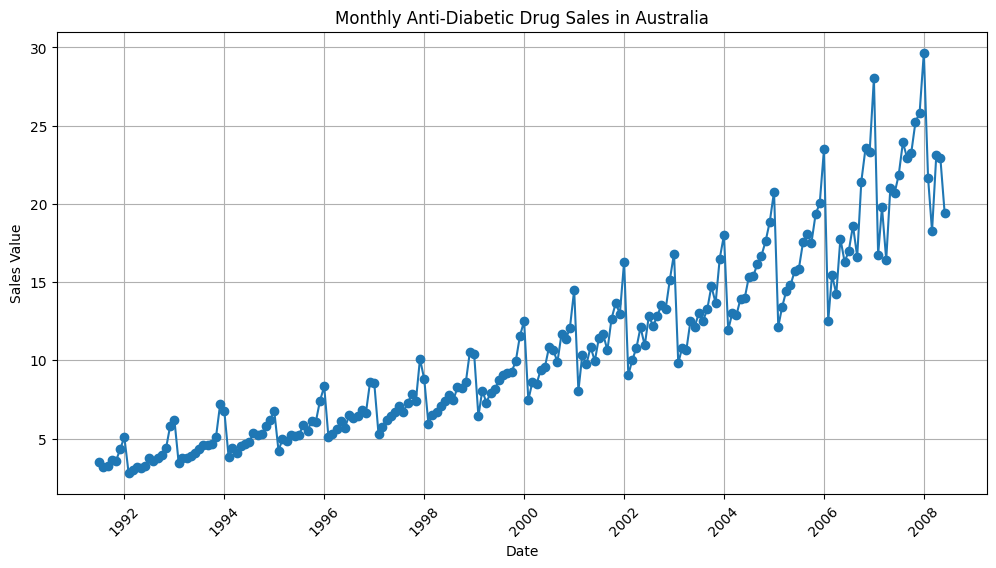

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(drug_sales_df.index, drug_sales_df['value'], marker='o', linestyle='-')
plt.title('Monthly Anti-Diabetic Drug Sales in Australia')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


#### Train-test-split

In [7]:
# The train data for each train-test set is months prior to the designated test period

def split_time_series(data, start_test_dates):
    split_data = {}
    for start_test in start_test_dates:
        # Define train and test end dates
        test_end = pd.to_datetime(start_test) + pd.DateOffset(months=11)  # 12 months total
        train_end = pd.to_datetime(start_test) - pd.DateOffset(months=1)

        # Create train and test datasets
        train_data = data[:train_end]
        test_data = data[start_test:test_end]

        # Naming with start date for the test set
        train_name = f'train_data_{start_test.strftime("%Y%m%d")}'
        test_name = f'test_data_{start_test.strftime("%Y%m%d")}'

        # Store in dictionary
        split_data[train_name] = train_data
        split_data[test_name] = test_data

    return split_data

start_test_dates = [
    pd.Timestamp('2004-07-01'),
    pd.Timestamp('2005-07-01'),
    pd.Timestamp('2006-07-01'),
    pd.Timestamp('2007-07-01')
]

split_datasets = split_time_series(drug_sales_df, start_test_dates)

# for name, dataset in split_datasets.items():
#     print(f"\n{name}:\n{dataset.head()}")


In [8]:
train_data_20040701 = split_datasets['train_data_20040701']
test_data_20040701 = split_datasets['test_data_20040701']

train_data_20050701 = split_datasets['train_data_20050701']
test_data_20050701 = split_datasets['test_data_20050701']

train_data_20060701 = split_datasets['train_data_20060701']
test_data_20060701 = split_datasets['test_data_20060701']

train_data_20070701 = split_datasets['train_data_20070701']
test_data_20070701 = split_datasets['test_data_20070701']

In [9]:
# train_data_20070701
# test_data_20070701

## ETS

#### Simple (optimized)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


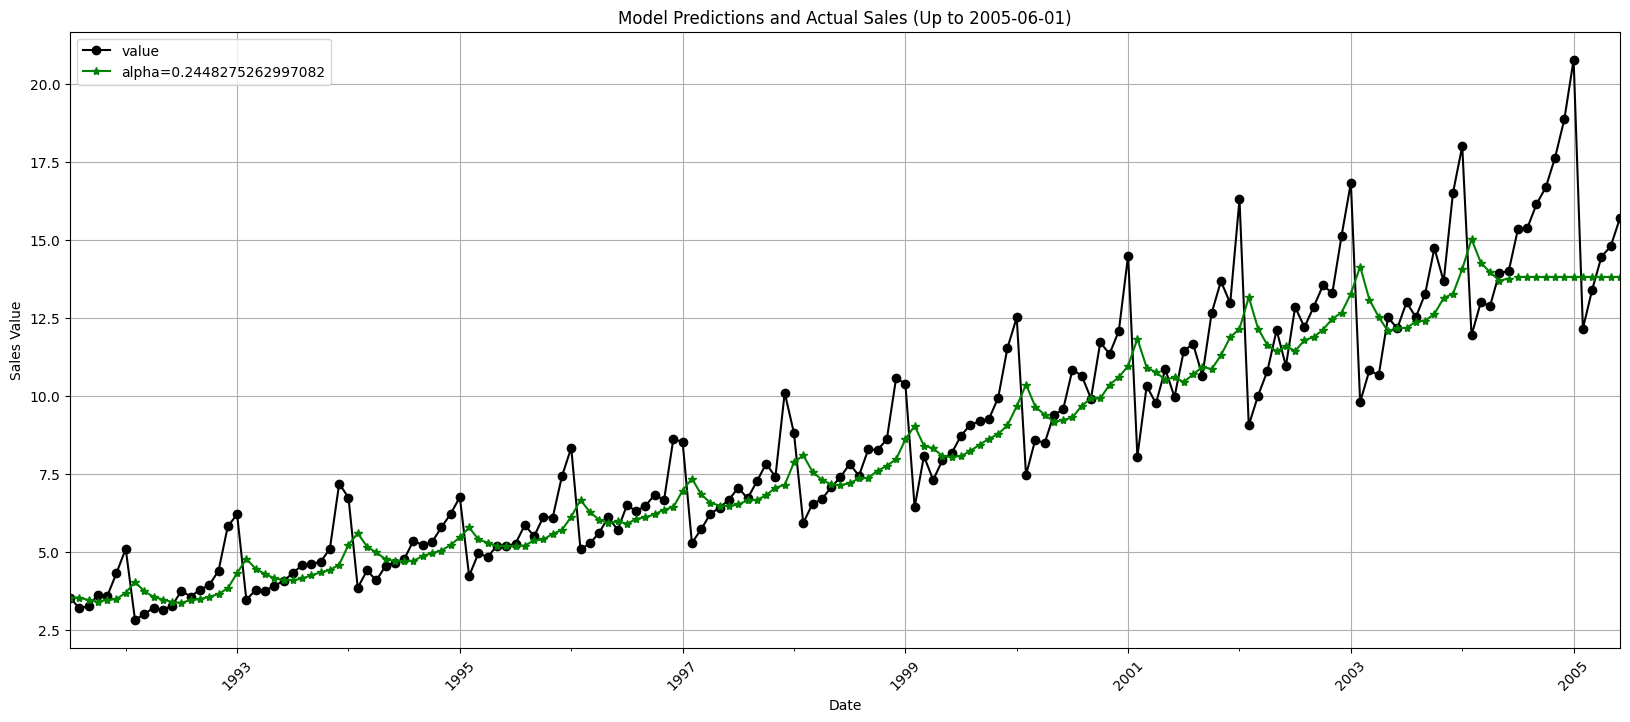

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


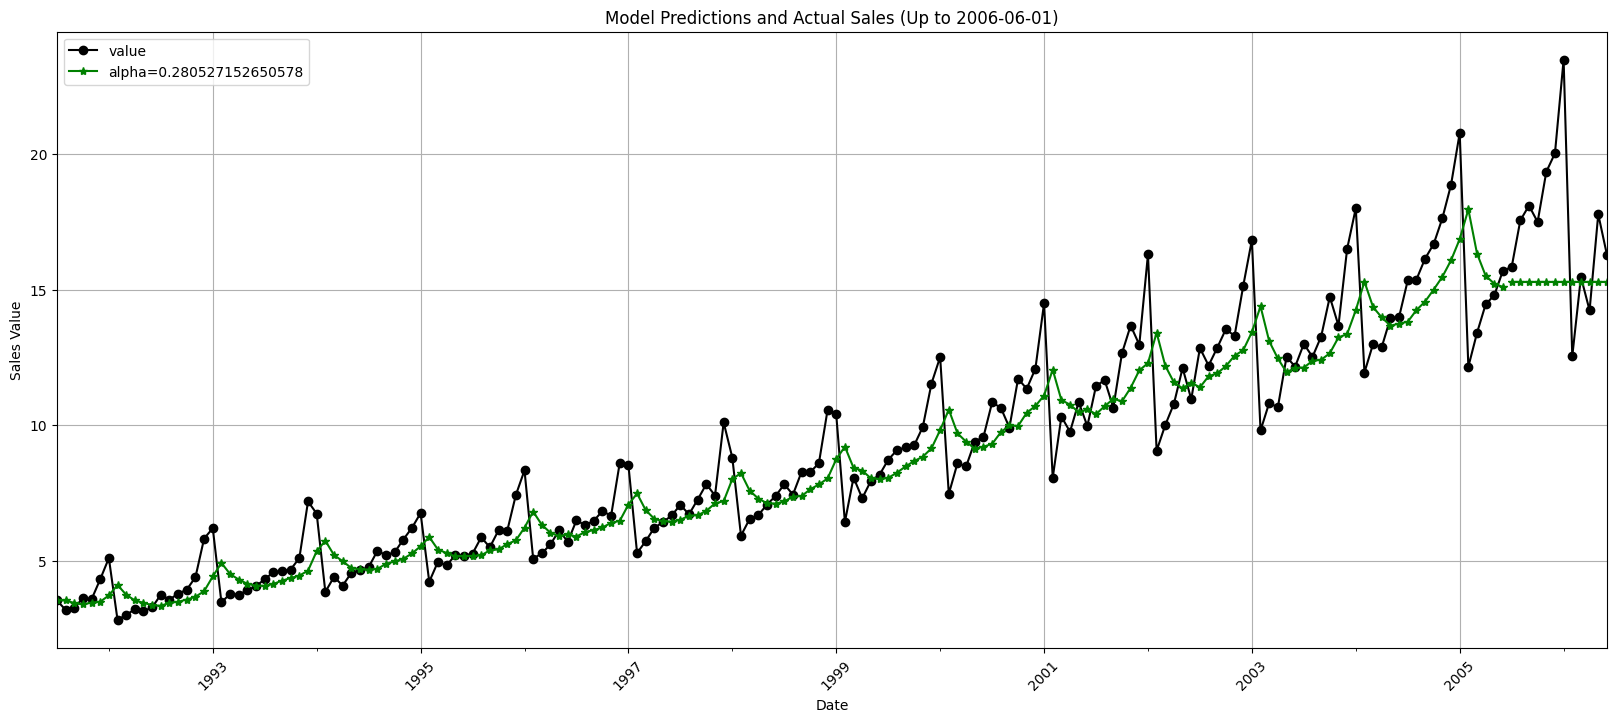

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


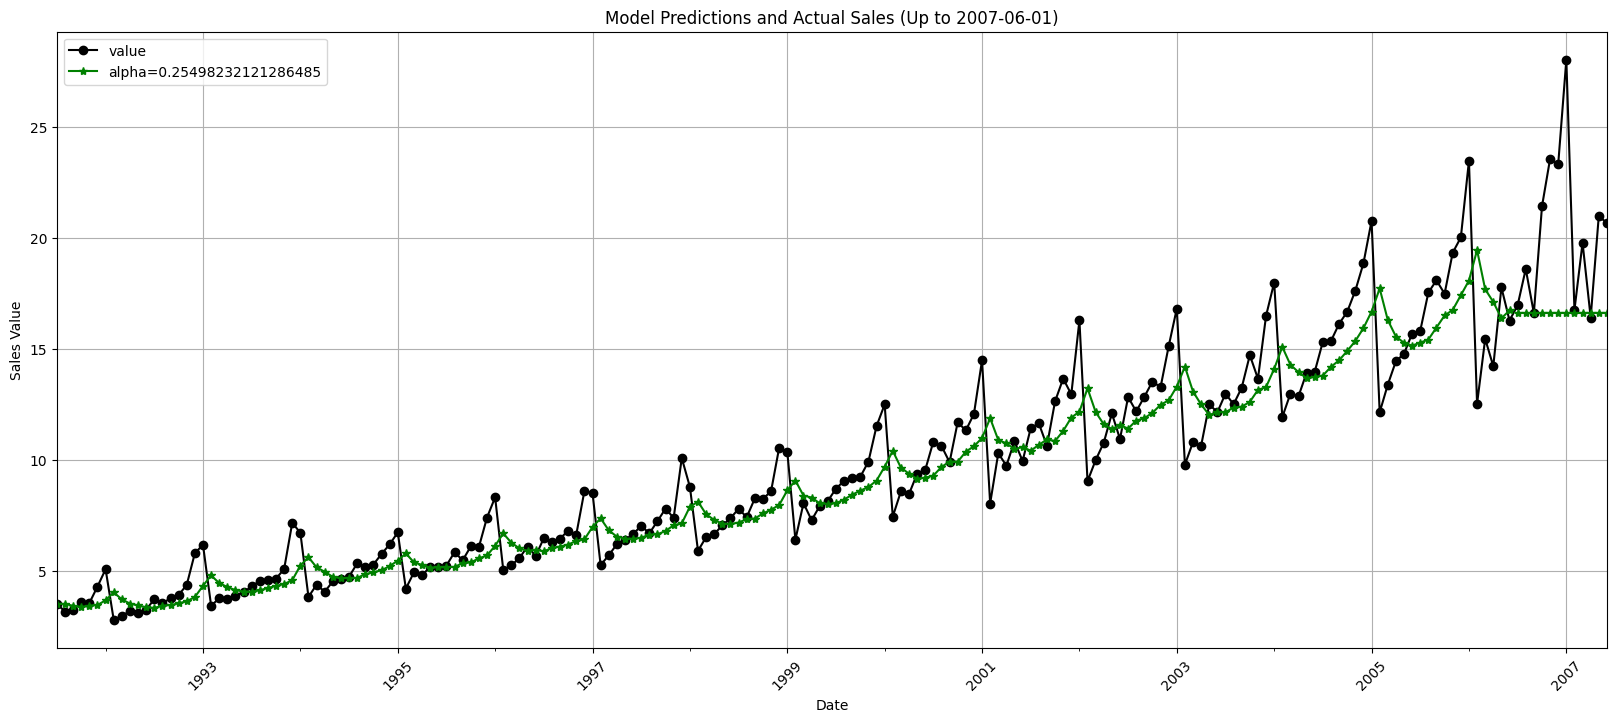

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


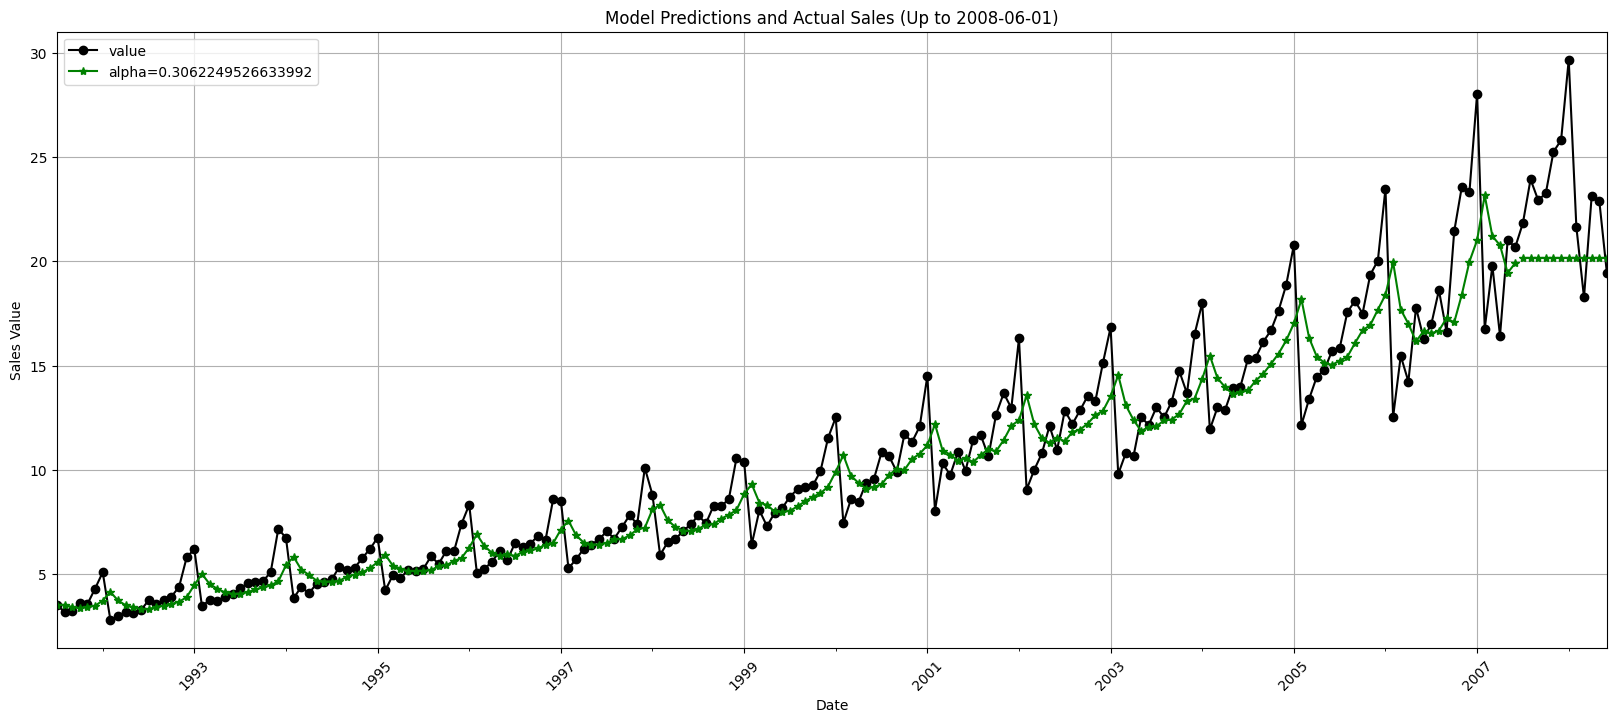

In [30]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.pyplot as plt

# Define a dictionary of train and test sets
datasets = {
    '20040701': (train_data_20040701, test_data_20040701, '2005-06-01'),
    '20050701': (train_data_20050701, test_data_20050701, '2006-06-01'),
    '20060701': (train_data_20060701, test_data_20060701, '2007-06-01'),
    '20070701': (train_data_20070701, test_data_20070701, '2008-06-01')
}

for key, (train_data, test_data, date_filter) in datasets.items():
    # Fit the model for each train dataset
    simple_ets_models = SimpleExpSmoothing(train_data).fit()
    forecast = simple_ets_models.forecast(12).rename(f'alpha={simple_ets_models.model.params["smoothing_level"]}')

    # Filter the DataFrame to include only data up to the given date
    filtered_df = drug_sales_df.loc[:date_filter]

    ax = filtered_df.plot(marker='o', color='black', figsize=(20, 8), legend=True)

    # Plot model predictions and fitted values
    forecast.loc[:date_filter].plot(marker='*', ax=ax, color='green', legend=True)
    simple_ets_models.fittedvalues.loc[:date_filter].plot(marker='*', ax=ax, color='green')

    plt.title(f'Model Predictions and Actual Sales (Up to {date_filter})')
    plt.xlabel('Date')
    plt.ylabel('Sales Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


#### Double

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


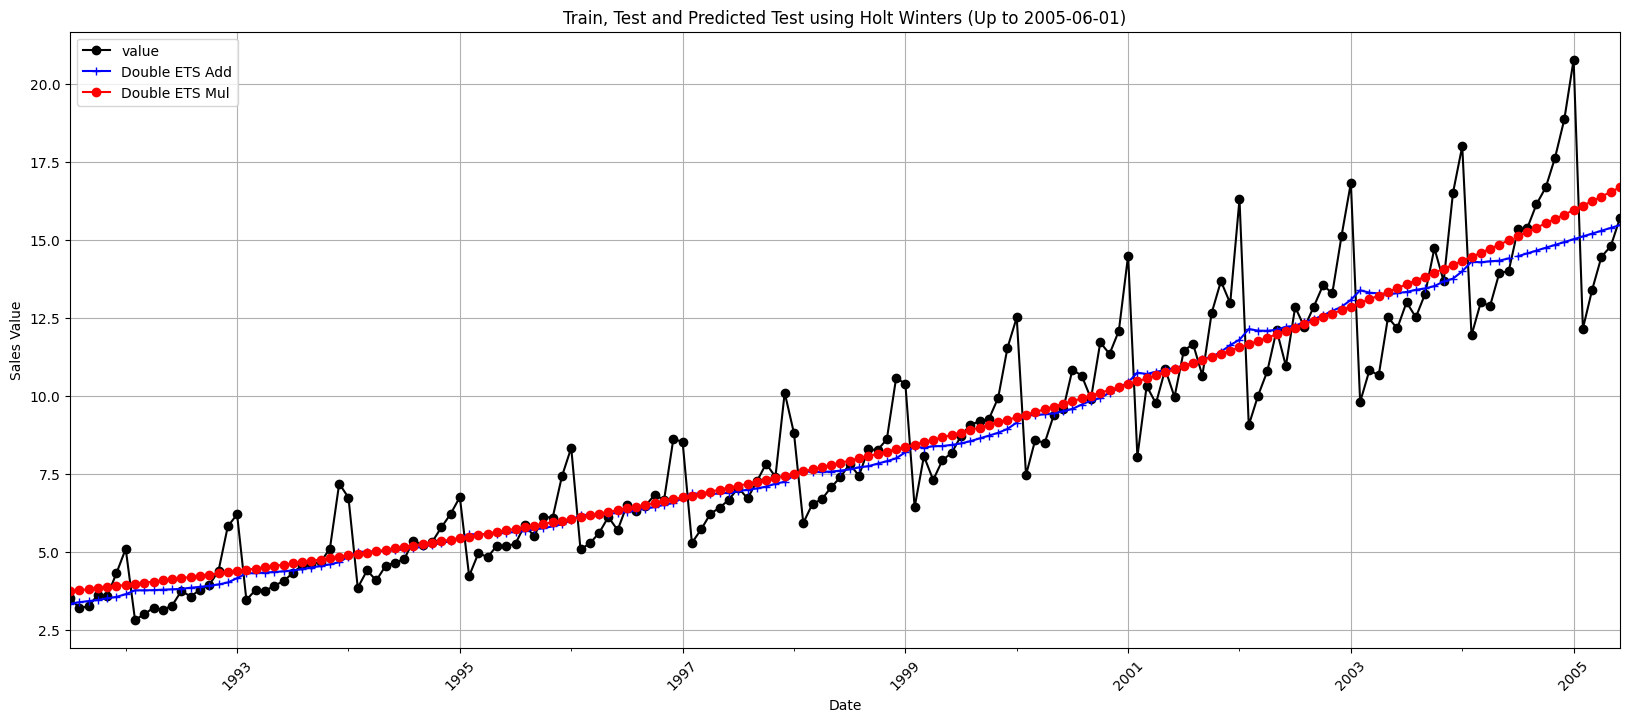

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


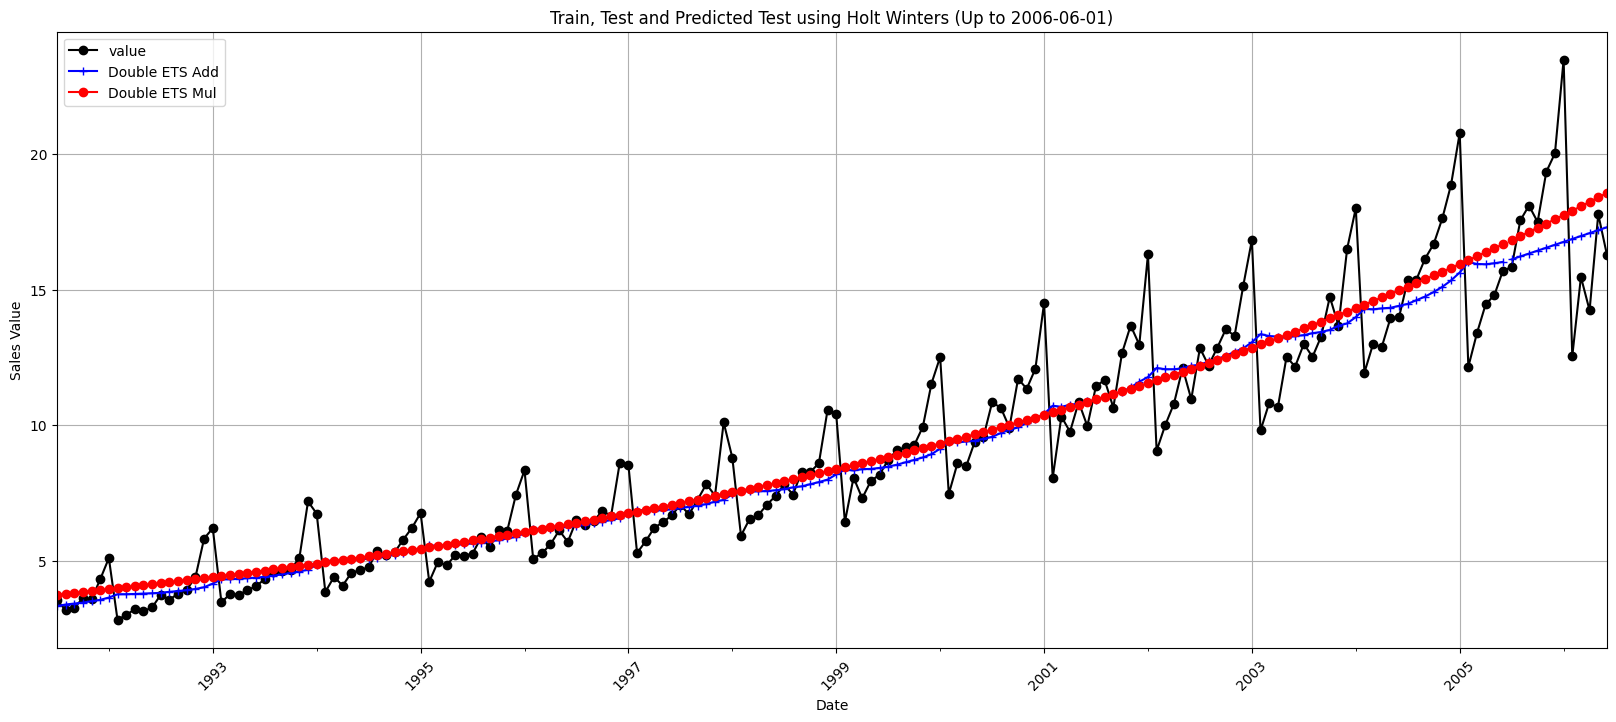

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


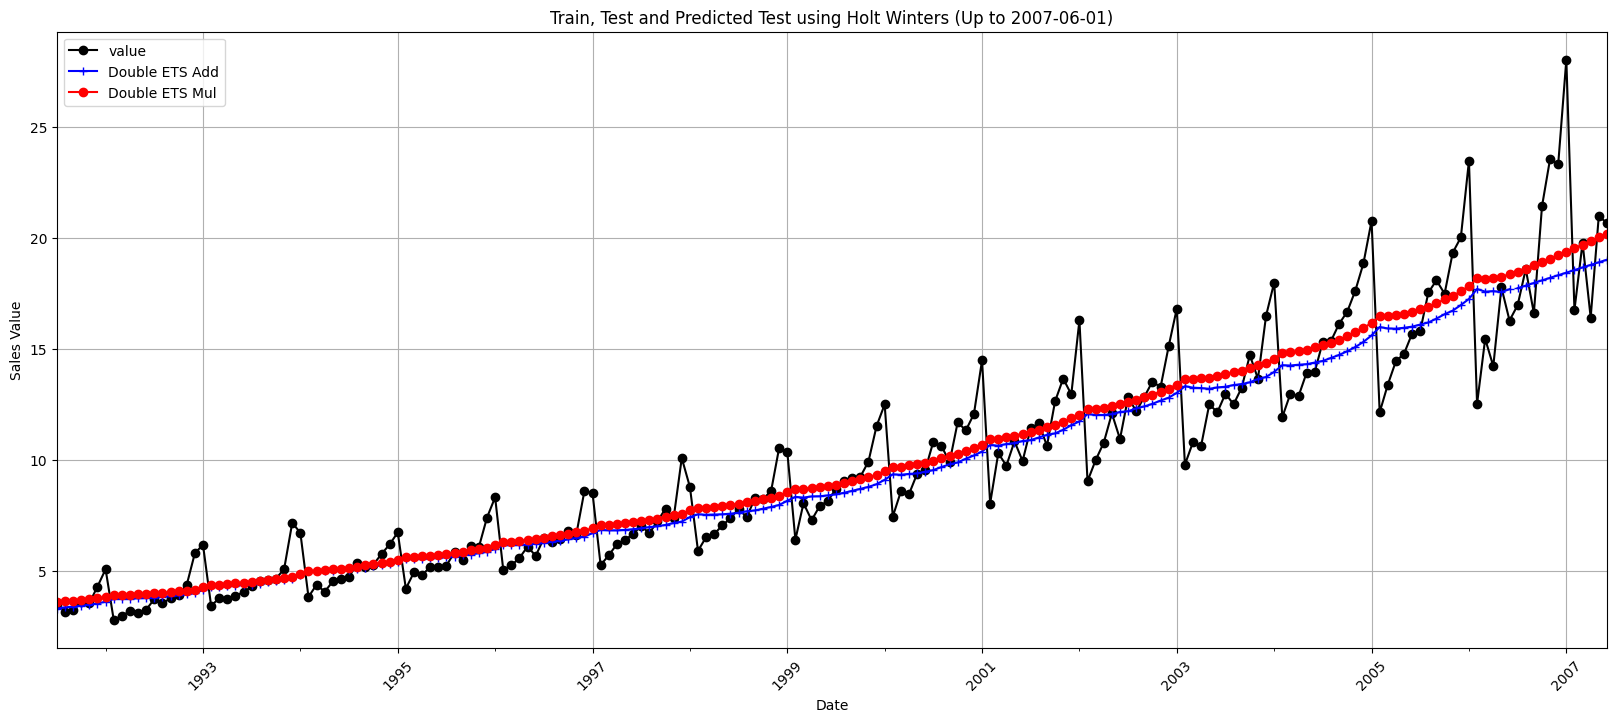

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


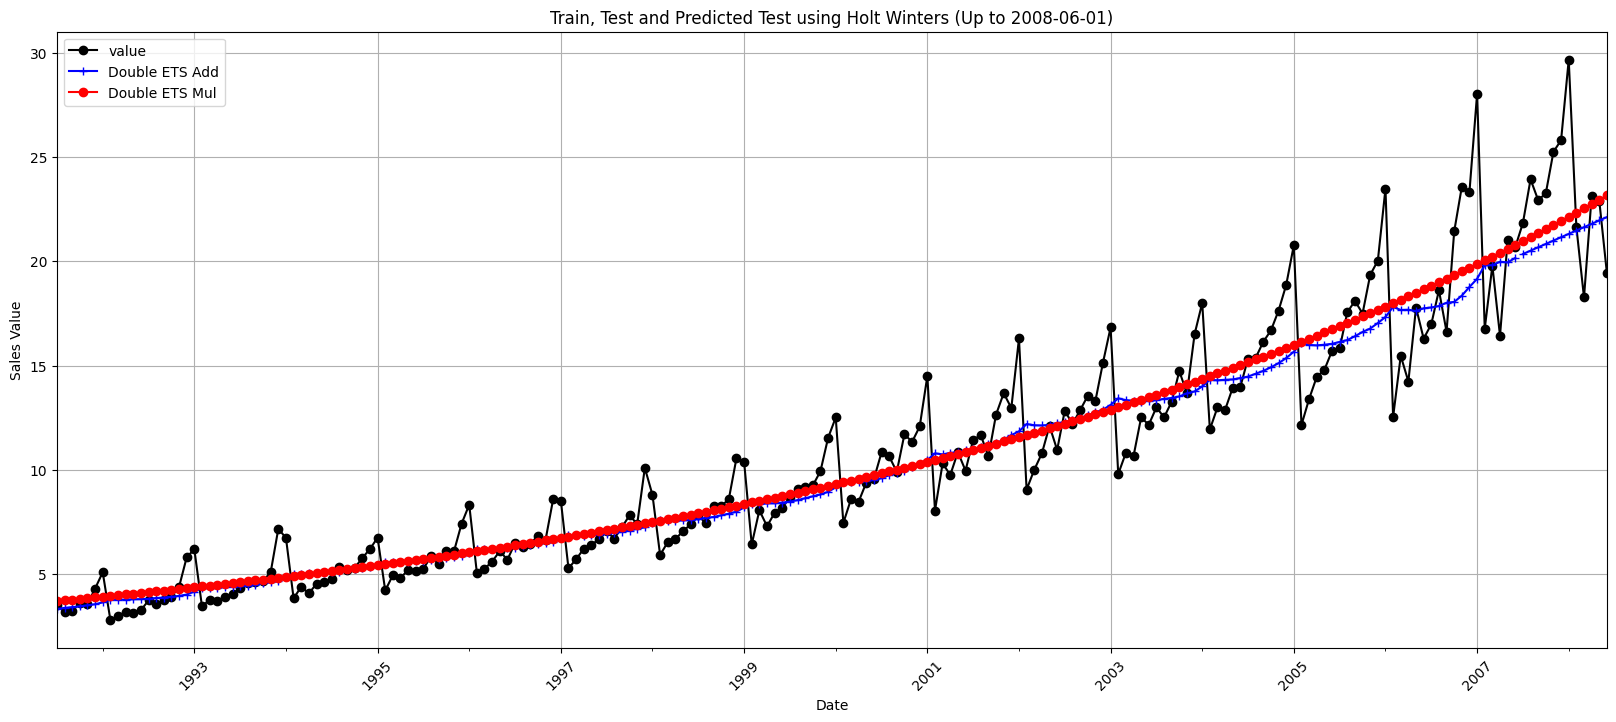

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt


for key, (train_data, test_data, date_filter) in datasets.items():
    # Fit Double ETS models for additive and multiplicative trends
    double_ets_add = ExponentialSmoothing(train_data, trend='add').fit()
    double_ets_mul = ExponentialSmoothing(train_data, trend='mul').fit()

    # Forecast for the next 12 periods
    double_ets_add_pred = double_ets_add.forecast(12)
    double_ets_mul_pred = double_ets_mul.forecast(12)

    # Filter the DataFrame to include only data up to the given date
    filtered_df = drug_sales_df.loc[:date_filter]

    ax = filtered_df.plot(marker='o', color='black', figsize=(20, 8), legend=True)

    # Plot for Double ETS Additive
    double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label='Double ETS Add')
    double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

    # Plot for Double ETS Multiplicative
    double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label='Double ETS Mul')
    double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

    plt.title(f'Train, Test and Predicted Test using Holt Winters (Up to {date_filter})')
    plt.xlabel('Date')
    plt.ylabel('Sales Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


#### Triple

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


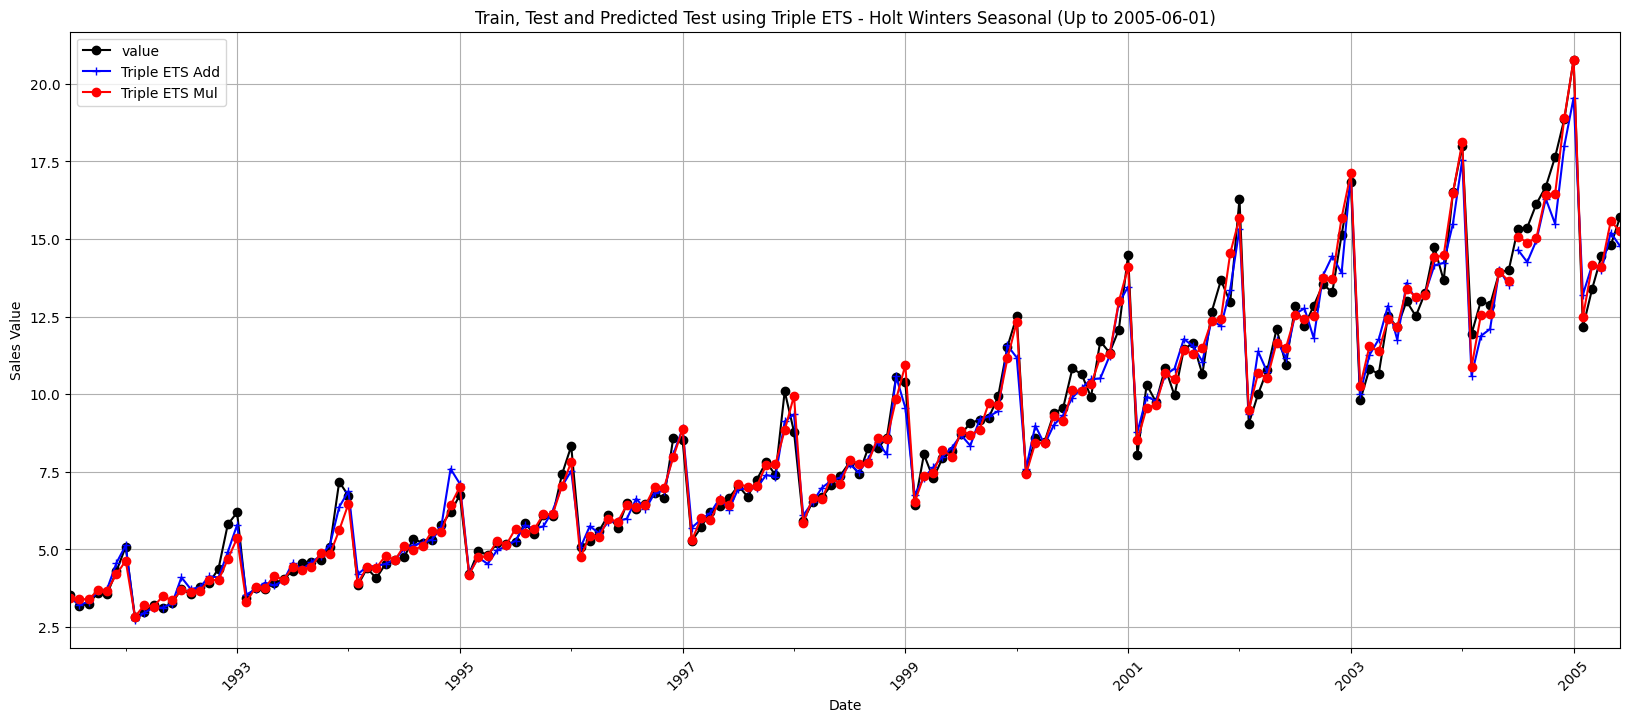

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


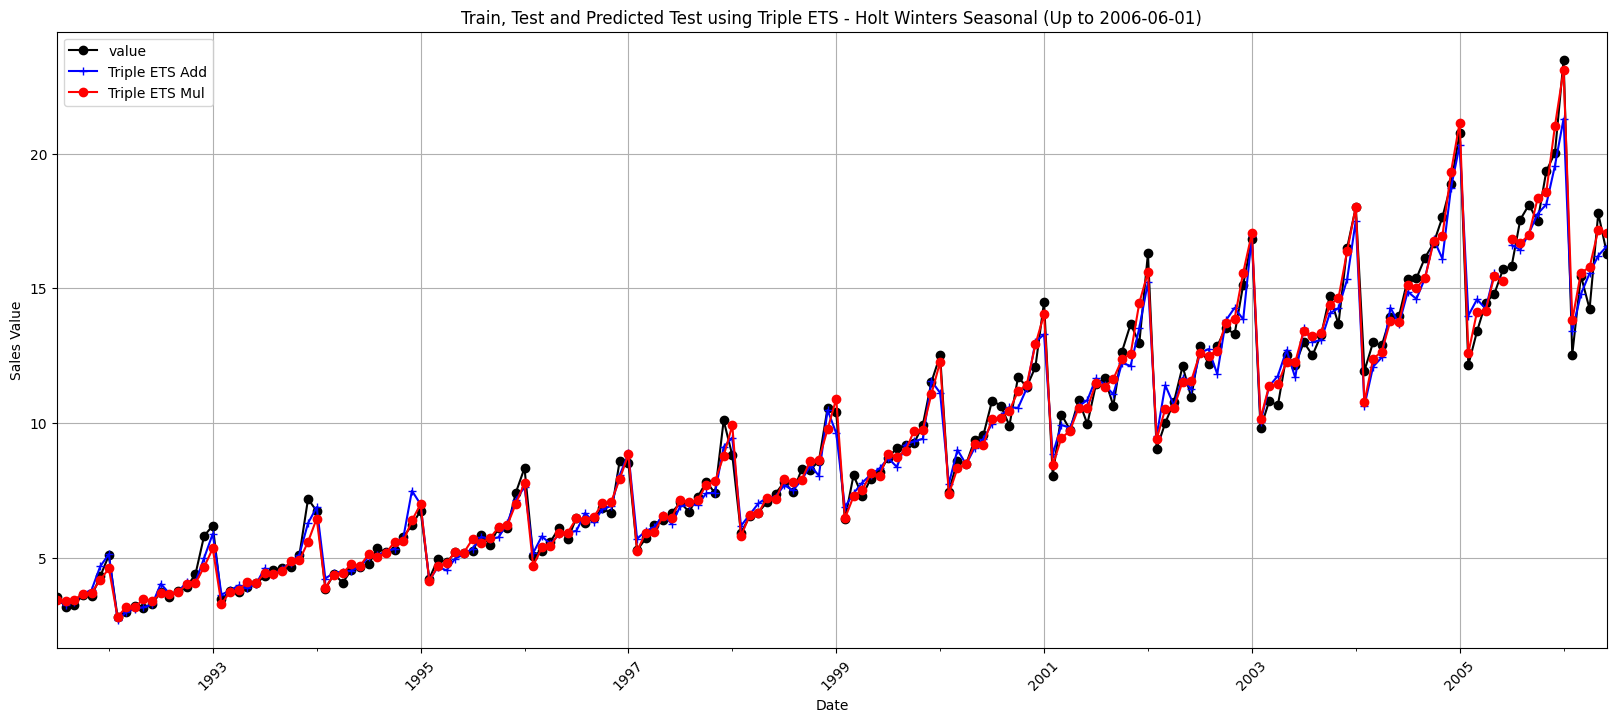

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


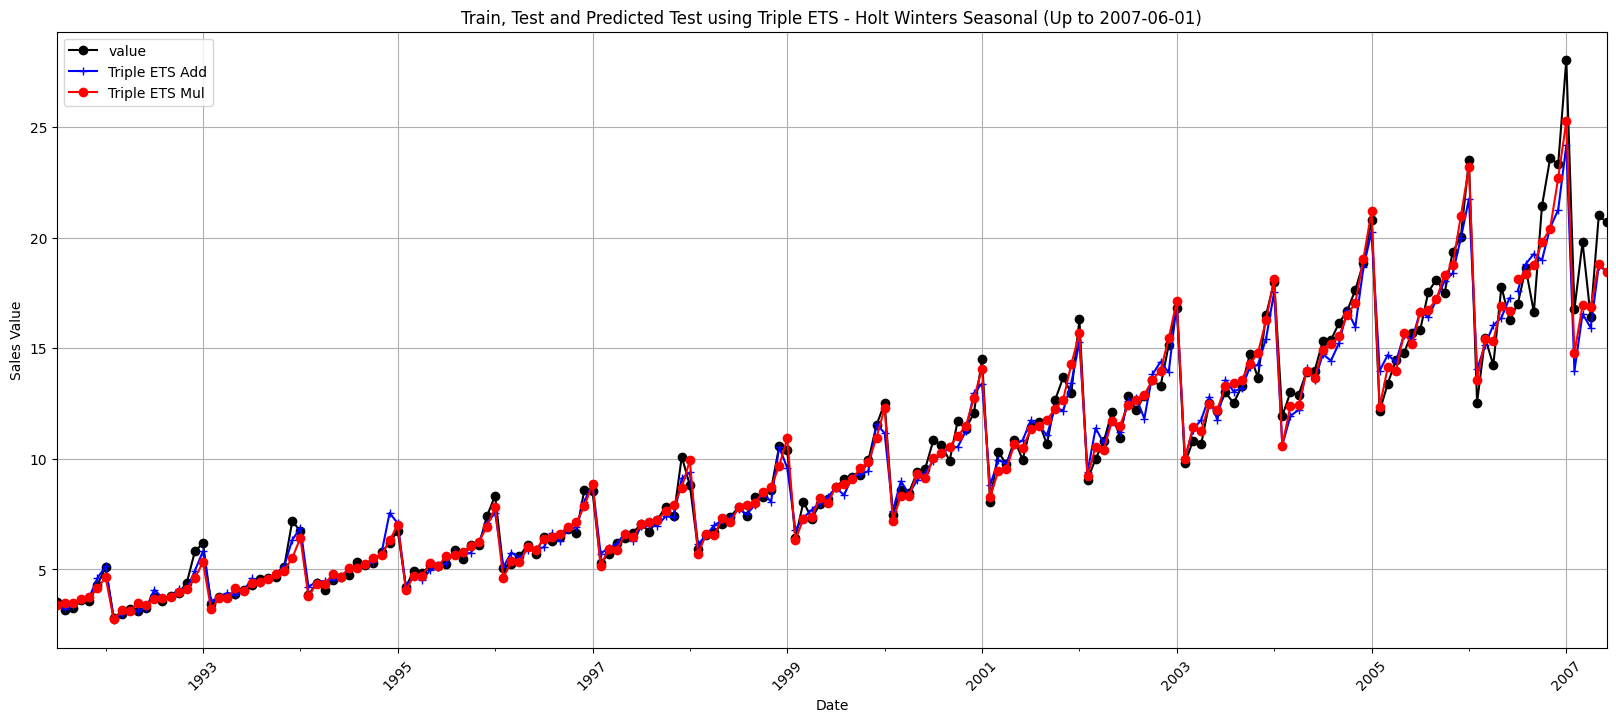

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


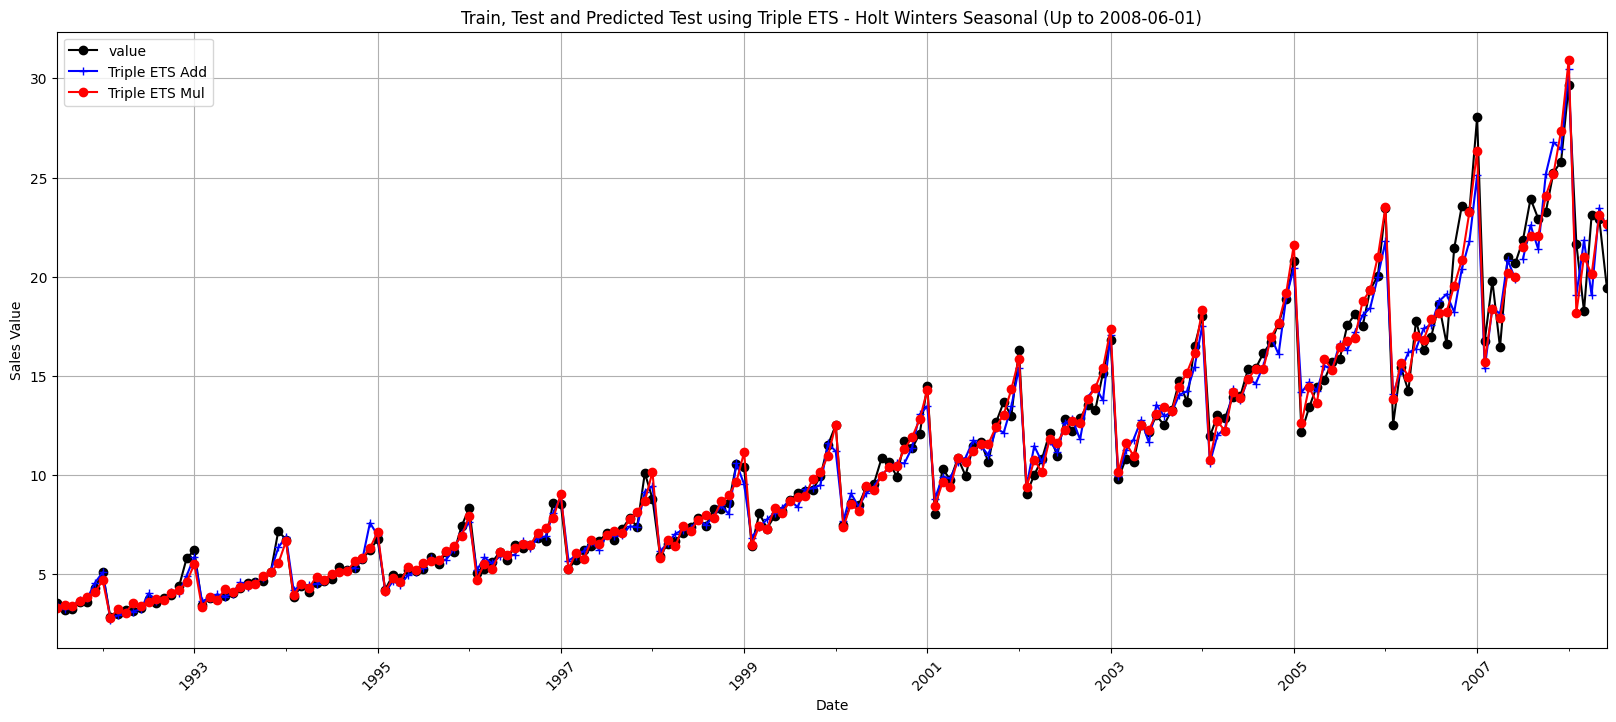

In [14]:
for key, (train_data, test_data, date_filter) in datasets.items():
    # Fit Triple ETS models for additive and multiplicative trends with seasonal components
    triple_ets_add = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit()
    triple_ets_mul = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12).fit()

    # Forecast for the next 12 periods
    triple_ets_add_pred = triple_ets_add.forecast(12)
    triple_ets_mul_pred = triple_ets_mul.forecast(12)

    # Filter the DataFrame to include only data up to the given date
    filtered_df = drug_sales_df.loc[:date_filter]

    ax = filtered_df.plot(marker='o', color='black', figsize=(20, 8), legend=True)

    # Plot for Triple ETS Additive
    triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label='Triple ETS Add')
    triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

    # Plot for Triple ETS Multiplicative
    triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label='Triple ETS Mul')
    triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

    plt.title(f'Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal (Up to {date_filter})')
    plt.xlabel('Date')
    plt.ylabel('Sales Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


## ARIMA

In [27]:
# train_data_20040701
# test_data_20040701

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=226.709, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=310.796, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=260.993, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=227.309, Time=0.53 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=229.668, Time=0.26 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=225.508, Time=0.72 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=228.659, Time=0.26 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=225.817, Time=1.16 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=226.347, Time=1.80 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=224.365, Time=1.06 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=224.161, Time=0.83 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=225.964, Time=1.86 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=225.121, Time=1.71 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=306.412, Time=1.58 sec
 ARIMA(0,1,2)(0,1,2)[12]         

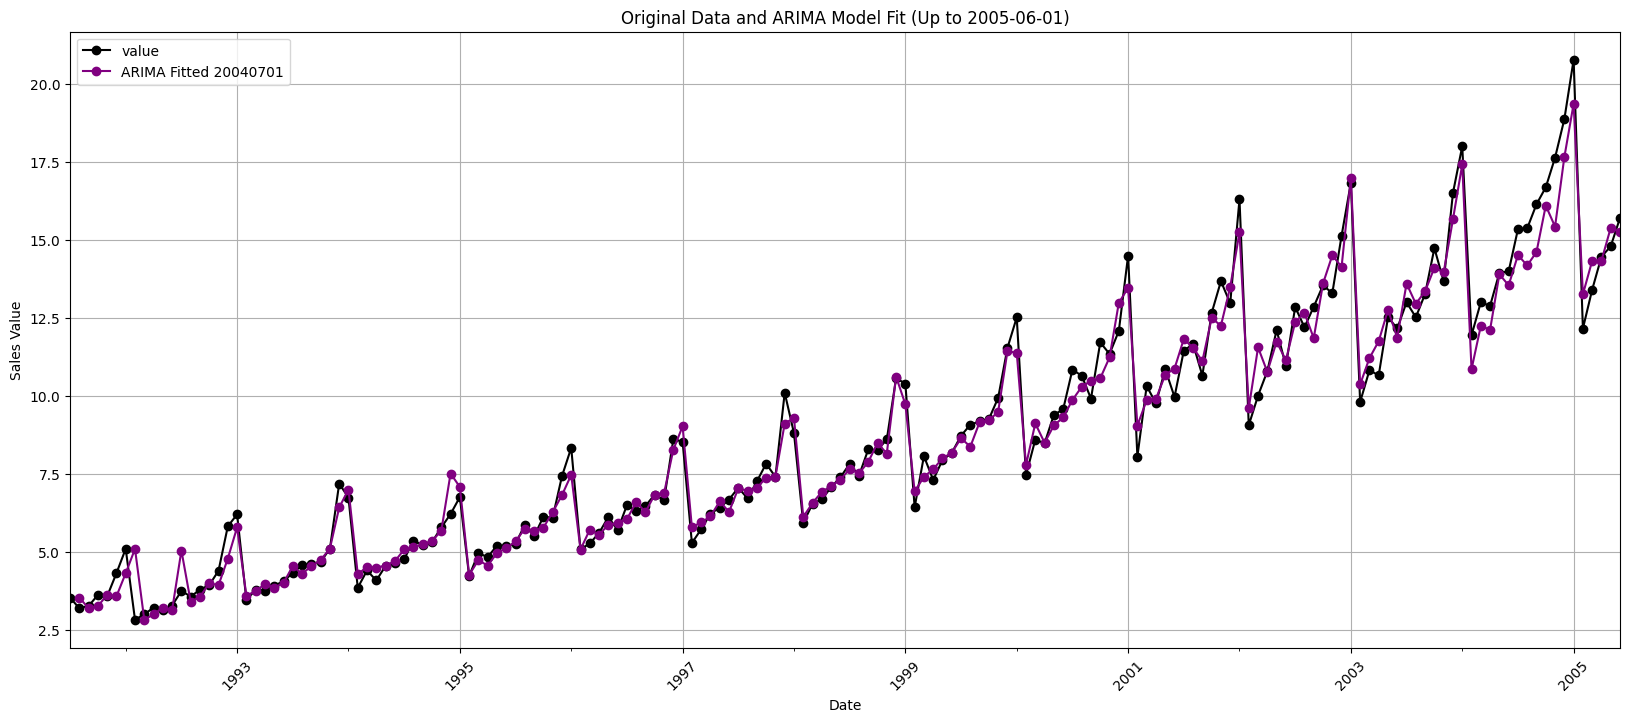

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=277.978, Time=1.44 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=328.707, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=307.343, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=317.216, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=495.695, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=284.962, Time=0.33 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=278.584, Time=6.46 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=281.078, Time=1.11 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=3.85 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=306.862, Time=0.35 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=277.468, Time=1.15 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=284.849, Time=0.37 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=27

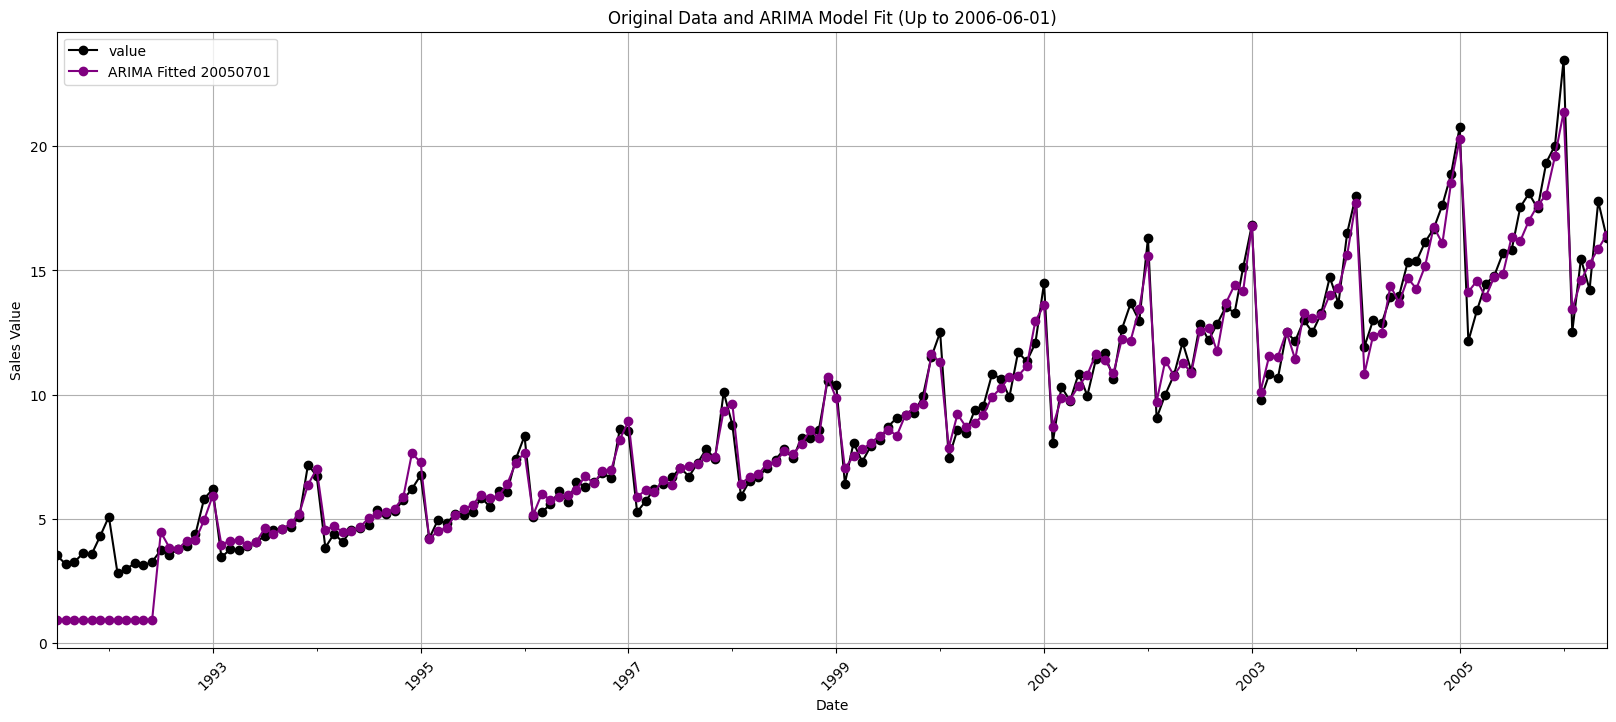

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=331.086, Time=1.55 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=369.596, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=362.402, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=367.046, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=546.314, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=332.975, Time=0.49 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=5.29 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=329.553, Time=4.57 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=335.075, Time=5.03 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=368.302, Time=0.81 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=362.333, Time=2.81 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=323.157, Time=4.97 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=323.874, Time=1.12 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=325.237, Time=5.39 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   

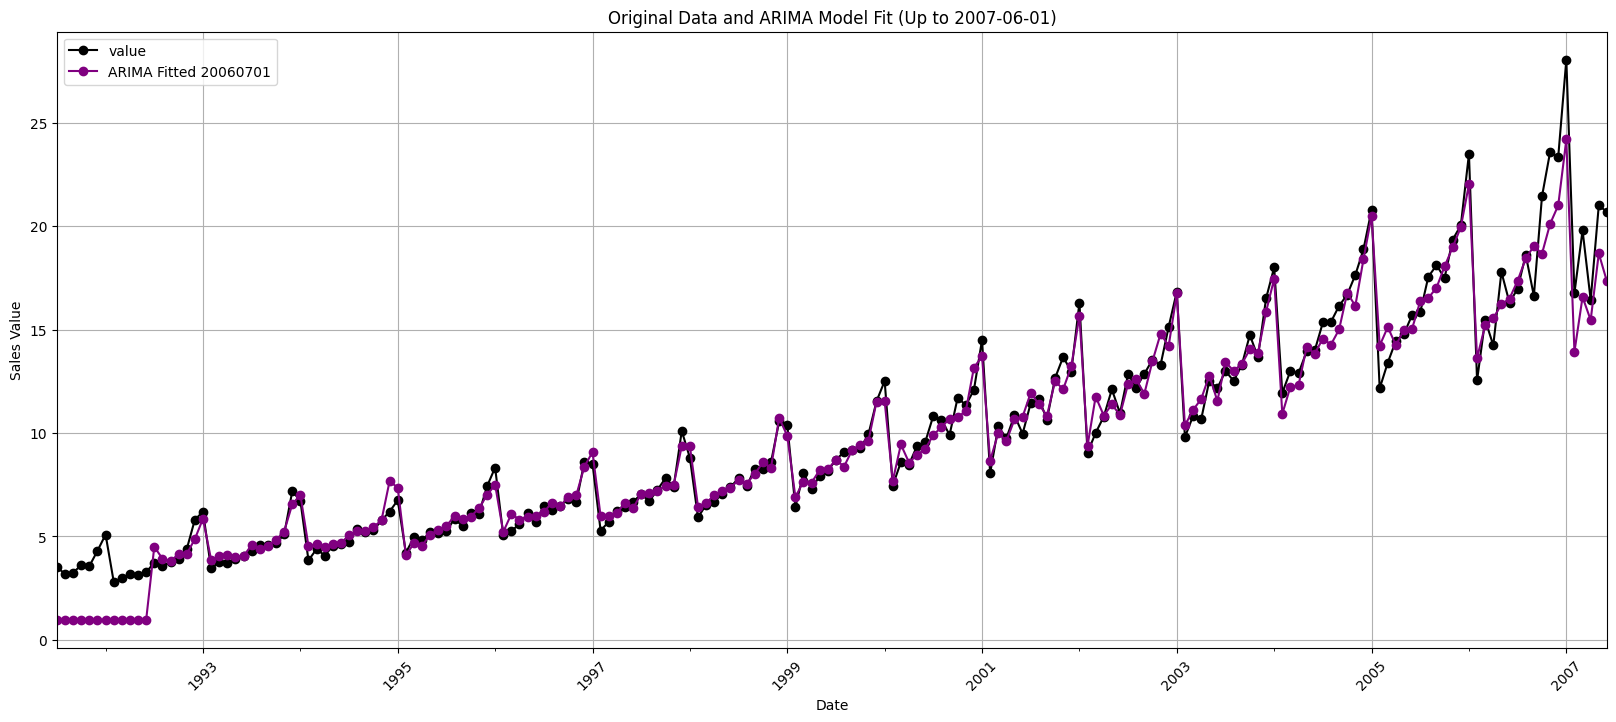

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=422.169, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=505.309, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=440.957, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=422.766, Time=0.26 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=423.219, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=423.200, Time=0.60 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=421.304, Time=1.10 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=420.235, Time=3.11 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=422.207, Time=2.53 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=420.588, Time=1.67 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=420.770, Time=4.42 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=435.856, Time=2.47 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=420.069, Time=2.87 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=420.743, Time=1.92 sec
 ARIMA(2,1,1)(1,1,1)[12]         

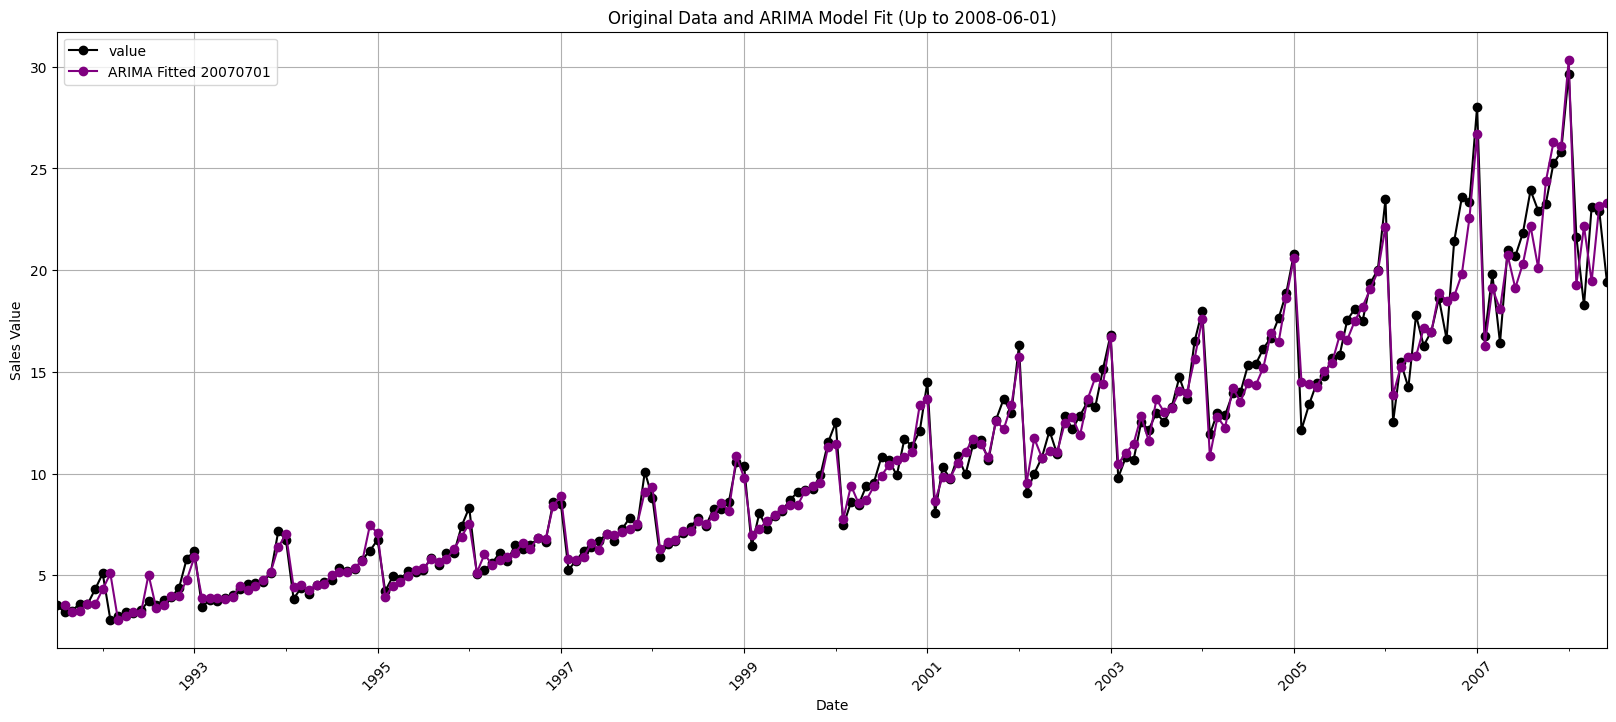

In [24]:
import pmdarima as pm

datasets = {
    '20040701': (train_data_20040701, test_data_20040701, '2005-06-01'),
    '20050701': (train_data_20050701, test_data_20050701, '2006-06-01'),
    '20060701': (train_data_20060701, test_data_20060701, '2007-06-01'),
    '20070701': (train_data_20070701, test_data_20070701, '2008-06-01')
}

for key, (train_data, test_data, date_filter) in datasets.items():
    # Fit the ARIMA model using auto_arima
    arima_model = pm.auto_arima(train_data,
                                    start_p=1, start_q=1,
                                    test='adf',
                                    max_p=3, max_q=3, m=12,
                                    start_P=0, seasonal=True,
                                    d=None, D=1,
                                    error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                trace = True)
    # Get the differencing order of the ARIMA model
    d = arima_model.order[1]

    # Combine train and test data for complete data range
    combined_data = pd.concat([train_data, test_data])

    # Predict using the model for the entire data range
    arima_fitted_full = arima_model.predict_in_sample(start=d, end=len(combined_data)-1)

    # Create a fitted series to match the index of combined data from d
    fitted_values_full = pd.Series(arima_fitted_full, index=combined_data.index[d:])

    # Create a plot
    ax = combined_data.plot(marker='o', color='black', figsize=(20, 8), legend=True, label='Original Data')

    # Plot the fitted values from the ARIMA model for the entire data range
    fitted_values_full.plot(marker='o', ax=ax, color='purple', legend=True, label=f'ARIMA Fitted {key}')

    plt.title(f'Original Data and ARIMA Model Fit (Up to {date_filter})')
    plt.xlabel('Date')
    plt.ylabel('Sales Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()


## Backtesting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages

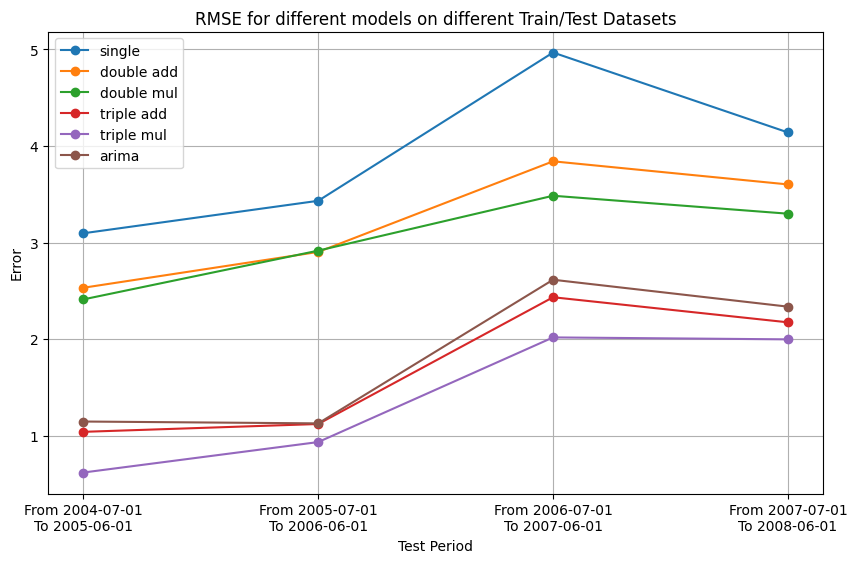

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima

# Define a function to perform backtesting for a given model and dataset
def backtesting(train_data, test_data, model_type):
    if model_type == 'single':
        model = ExponentialSmoothing(train_data).fit()
    elif model_type == 'double add':
        model = ExponentialSmoothing(train_data, trend='add').fit()
    elif model_type == 'double mul':
        model = ExponentialSmoothing(train_data, trend='mul').fit()
    elif model_type == 'triple add':
        model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit()
    elif model_type == 'triple mul':
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12).fit()
    elif model_type == 'arima':
        model = auto_arima(train_data, start_p=1, start_q=1, test='adf', max_p=3, max_q=3, m=12, seasonal=True, d=None, D=1, trace=False, error_action='ignore', suppress_warnings=True)
        return model.predict(n_periods=len(test_data))
    else:
        raise ValueError("Invalid model type specified.")

    return model.forecast(len(test_data))

datasets = {
    '20040701': (train_data_20040701, test_data_20040701),
    '20050701': (train_data_20050701, test_data_20050701),
    '20060701': (train_data_20060701, test_data_20060701),
    '20070701': (train_data_20070701, test_data_20070701)
}

models = ['single', 'double add', 'double mul', 'triple add', 'triple mul', 'arima']

rmse_results = {model: [] for model in models}

# Backtesting
for dataset_name, (train_data, test_data) in datasets.items():
    for model_type in models:
        # Get the forecasted values
        forecasted_values = backtesting(train_data, test_data, model_type)

        # Calculate the RMSE for the forecasted values
        rmse = sqrt(mean_squared_error(test_data, forecasted_values))

        # Store the RMSE value
        rmse_results[model_type].append(rmse)

# Plotting the RMSE results
plt.figure(figsize=(10, 6))
test_periods = ['From 2004-07-01\nTo 2005-06-01', 'From 2005-07-01\nTo 2006-06-01',
                'From 2006-07-01\nTo 2007-06-01', 'From 2007-07-01\nTo 2008-06-01']

# Plot each model's RMSE values
for model_type, rmse_values in rmse_results.items():
    plt.plot(test_periods, rmse_values, marker='o', label=model_type)

# Set the plot labels and title
plt.title('RMSE for different models on different Train/Test Datasets')
plt.xlabel('Test Period')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages

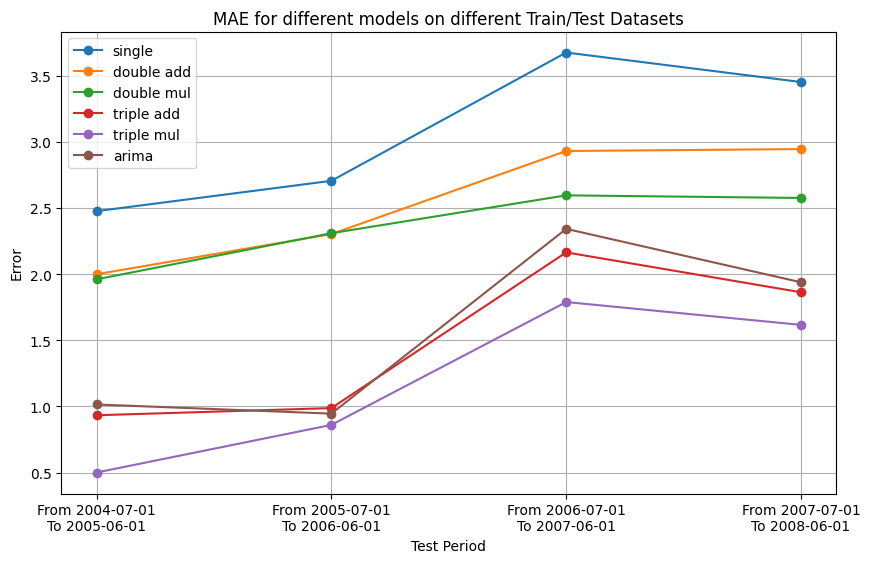

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima

# Define a function to perform backtesting for a given model and dataset
def backtesting(train_data, test_data, model_type):
    if model_type == 'single':
        model = ExponentialSmoothing(train_data).fit()
    elif model_type == 'double add':
        model = ExponentialSmoothing(train_data, trend='add').fit()
    elif model_type == 'double mul':
        model = ExponentialSmoothing(train_data, trend='mul').fit()
    elif model_type == 'triple add':
        model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit()
    elif model_type == 'triple mul':
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12).fit()
    elif model_type == 'arima':
        model = auto_arima(train_data, start_p=1, start_q=1, test='adf', max_p=3, max_q=3, m=12, seasonal=True, d=None, D=1, trace=False, error_action='ignore', suppress_warnings=True)
        return model.predict(n_periods=len(test_data))
    else:
        raise ValueError("Invalid model type specified.")

    return model.forecast(len(test_data))

datasets = {
    '20040701': (train_data_20040701, test_data_20040701),
    '20050701': (train_data_20050701, test_data_20050701),
    '20060701': (train_data_20060701, test_data_20060701),
    '20070701': (train_data_20070701, test_data_20070701)
}

models = ['single', 'double add', 'double mul', 'triple add', 'triple mul', 'arima']

# Store the MAE results
mae_results = {model: [] for model in models}

# Backtesting
for dataset_name, (train_data, test_data) in datasets.items():
    for model_type in models:
        # Get the forecasted values
        forecasted_values = backtesting(train_data, test_data, model_type)

        # Calculate the MAE for the forecasted values
        mae = mean_absolute_error(test_data, forecasted_values)

        # Store the MAE value
        mae_results[model_type].append(mae)

# Plotting the MAE results
plt.figure(figsize=(10, 6))
test_periods = ['From 2004-07-01\nTo 2005-06-01', 'From 2005-07-01\nTo 2006-06-01',
                'From 2006-07-01\nTo 2007-06-01', 'From 2007-07-01\nTo 2008-06-01']

# Plot each model's MAE values
for model_type, mae_values in mae_results.items():
    plt.plot(test_periods, mae_values, marker='o', label=model_type)

plt.title('MAE for different models on different Train/Test Datasets')
plt.xlabel('Test Period')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages

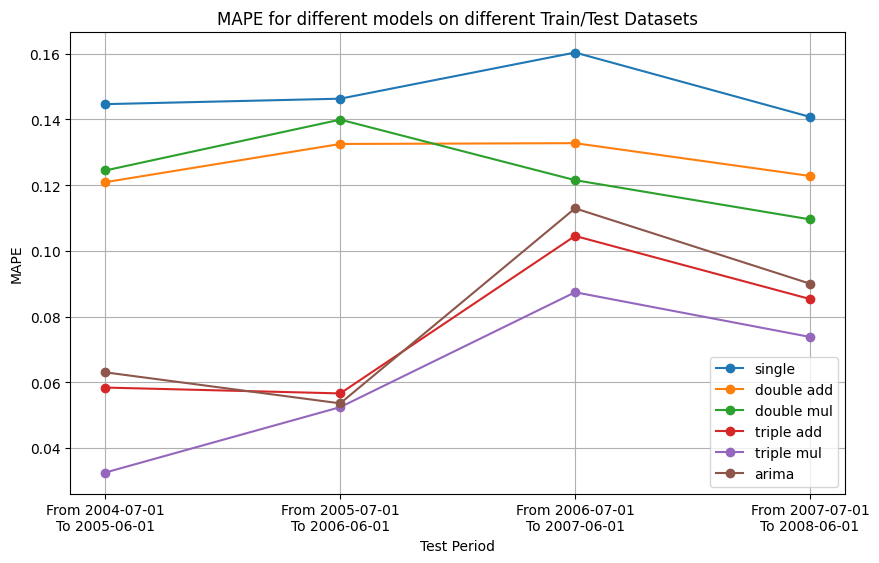

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima

# Define a function to perform backtesting for a given model and dataset
def backtesting(train_data, test_data, model_type):
    if model_type == 'single':
        model = ExponentialSmoothing(train_data).fit()
    elif model_type == 'double add':
        model = ExponentialSmoothing(train_data, trend='add').fit()
    elif model_type == 'double mul':
        model = ExponentialSmoothing(train_data, trend='mul').fit()
    elif model_type == 'triple add':
        model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit()
    elif model_type == 'triple mul':
        model = ExponentialSmoothing(train_data, trend='mul', seasonal='mul', seasonal_periods=12).fit()
    elif model_type == 'arima':
        model = auto_arima(train_data, start_p=1, start_q=1, test='adf', max_p=3, max_q=3, m=12, seasonal=True, d=None, D=1, trace=False, error_action='ignore', suppress_warnings=True)
        return model.predict(n_periods=len(test_data))
    else:
        raise ValueError("Invalid model type specified.")

    return model.forecast(len(test_data))

# Define the datasets and test periods
datasets = {
    '20040701': (train_data_20040701, test_data_20040701),
    '20050701': (train_data_20050701, test_data_20050701),
    '20060701': (train_data_20060701, test_data_20060701),
    '20070701': (train_data_20070701, test_data_20070701)
}

models = ['single', 'double add', 'double mul', 'triple add', 'triple mul', 'arima']

# Store the MAPE results
mape_results = {model: [] for model in models}

# Backtesting
for dataset_name, (train_data, test_data) in datasets.items():
    for model_type in models:
        # Get the forecasted values
        forecasted_values = backtesting(train_data, test_data, model_type)

        # Calculate the MAPE for the forecasted values
        mape = mean_absolute_percentage_error(test_data, forecasted_values)

        # Store the MAPE value
        mape_results[model_type].append(mape)

# Plotting the MAPE results
plt.figure(figsize=(10, 6))
test_periods = ['From 2004-07-01\nTo 2005-06-01', 'From 2005-07-01\nTo 2006-06-01',
                'From 2006-07-01\nTo 2007-06-01', 'From 2007-07-01\nTo 2008-06-01']

# Plot each model's MAPE values
for model_type, mape_values in mape_results.items():
    plt.plot(test_periods, mape_values, marker='o', label=model_type)

plt.title('MAPE for different models on different Train/Test Datasets')
plt.xlabel('Test Period')
plt.ylabel('MAPE')
plt.legend()
plt.grid()
plt.show()


Based on the evaluation metrics (RMSE, MAE, and MAPE), the Triple Exponential Smoothing model with a multiplicative trend and seasonality has the lowest error values across all measures, indicating that it is the best performing model.